# braga2024datasetname
This notebook aims to provide a demonstration of how to use the colorcloud library for preprocessing and displaying the results of ufg_dataset point clouds projected in 2D. For more information, visit [00_behley2019iccv](https://air-ufg.github.io/colorcloud/behley2019iccv.html) documentation.

## Importing Libraries

In [9]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torch import nn

from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import yaml

from colorcloud.behley2019iccv import SemanticKITTIDataset, SphericalProjection, ProjectionTransform, ProjectionVizTransform

## Data Processing

To load and preprocess the data, download and extract the dataset folder by [clicking here](https://drive.google.com/file/d/19CJgn-KNEVMukH9dKpxo2BftuuvDq6BV/view?usp=drive_link) and move it to a folder named *data* at the root of your workspace. Remember to set the ufg_dataset flag to *True* since we are not working with the Semantic KITTI dataset.

In [10]:
data_path = '/workspace/data/UFG-Dataset-Labaled/'
ds = SemanticKITTIDataset(data_path, ufg_dataset=True)
val_ds = SemanticKITTIDataset(data_path, split='valid', ufg_dataset=True)
test_ds = SemanticKITTIDataset(data_path, split='test', ufg_dataset=True)
print(f'train size:\t{len(ds)}\nval size:\t{len(val_ds)}\ntest size:\t{len(test_ds)}')

train size:	2374
val size:	0
test size:	0


In [11]:
item = ds[679]
frame = item['frame']
mask = item['mask']
frame, frame.shape

(array([[-4.3508749e+00,  4.3997469e+00, -1.6579949e+00,  2.3529412e-02],
        [-5.0064950e+00,  5.0662694e+00, -1.6443924e+00,  2.3529412e-02],
        [-5.9493732e+00,  6.0225039e+00, -1.6455369e+00,  1.5686275e-02],
        ...,
        [-4.7362103e+01,  5.3158035e+01,  1.1276423e+01,  2.4705882e-01],
        [-1.0994964e+01,  1.2349147e+01,  3.2139866e+00,  5.0980393e-02],
        [-9.4547243e+00,  1.0626677e+01,  3.2838356e+00,  3.1372551e-02]],
       dtype=float32),
 (20503, 4))

In [12]:
label = item['label']
label, label.shape, label.dtype, set(label)

(array([ 9,  9,  9, ...,  0, 15, 15], dtype=uint32),
 (20503,),
 dtype('uint32'),
 {0, 1, 6, 9, 11, 15})

In [13]:
mask = item['mask']
mask, mask.shape, mask.dtype

(array([ True,  True,  True, ..., False,  True,  True]),
 (20503,),
 dtype('bool'))

## Data Projection

If you want to visualize the projection results, you will need a function to display them. The function below can serve as a good starting point for demonstrating the results."

In [14]:
def plot_projections(img, label):
    fig, axs = plt.subplots(6, 1, figsize=(20,10), layout='compressed')
    for i, (ax, title) in enumerate(zip(axs, ['x', 'y', 'z', 'r', 'd', 'label'])):
        if i < 5:
            ax.imshow(img[:,:,i])
        else:
            ax.imshow(label)
        ax.set_title(title)
        ax.axis('off')

The sensor used for data collection was a Velodyne LiDAR PUCK 16, which has a field of view (FOV) of +/- 15 degrees up and down. For more information about the LiDAR specifications, [click here](https://www.amtechs.co.jp/product/VLP-16-Puck.pdf).

The scaling values were defined by analyzing the entire dataset, seeking the minimum and maximum values for each feature.

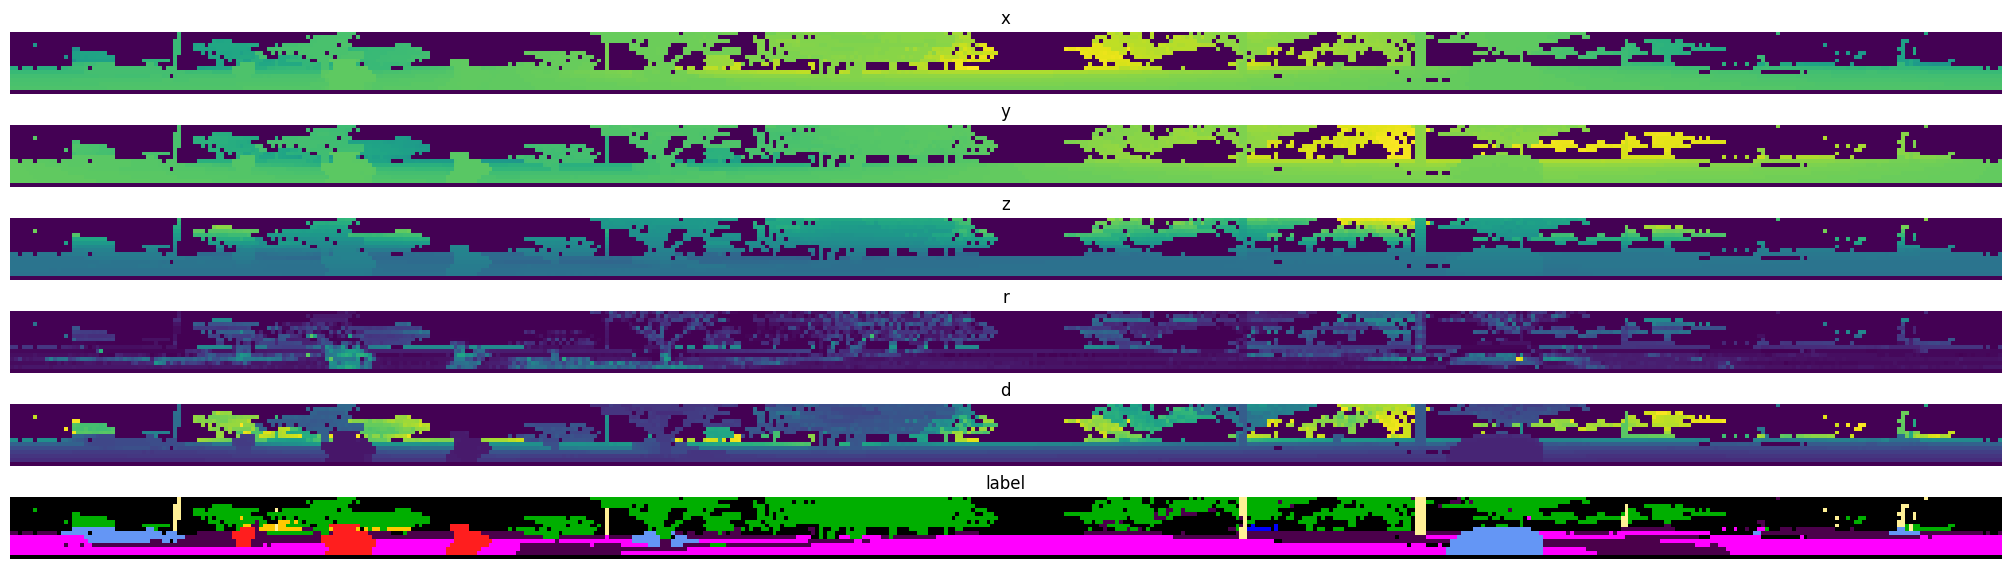

In [74]:
proj = SphericalProjection(fov_up_deg=15., fov_down_deg=-15., W=512, H=16)  # these values were taken from [https://github.com/PRBonn/semantic-kitti-api/blob/master/auxiliary/laserscan.py]
scaling_values = {
    "x" : {"min": -150., "max":150.},
    "y" : {"min": -150., "max":150.},
    "z" : {"min": -10., "max":30.},
    "r" : {"min": 0., "max":1.},
    "d" : {"min": 0., "max":130.}
}
tfms = v2.Compose([
    ProjectionTransform(proj),
    ProjectionVizTransform(ds.color_map_rgb_np, ds.learning_map_inv_np, scaling_values),
])
ds.set_transform(tfms)
item = ds[100]
img = item['frame']
label = item['label']

plot_projections(img, label)